In [5]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt



In [11]:
#importing the data to the list
with open('intent.json') as content:
  data1=json.load(content)


In [12]:
#getting all the data to the list
tags=[]
inputs=[]
responses={}

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [13]:
#converting to dataframe
data=pd.DataFrame({"inputs": inputs,
                  "tags": tags})

In [14]:
#printing the data
data

,inputs,tags
0,google,google
1,search,google
2,internet,google
3,how to get recruited ?,join
4,how to join ?,join
...,...,...
113,Ask me a question,riddle
114,Riddle,riddle
115,how old are you,age
116,when were you made,age


In [15]:
data=data.sample(frac=1)

**Pre**-**Processing**

In [16]:
#removing punctutaions
import string
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
77,contact programmer,contact
114,riddle,riddle
18,see you later,goodbye
95,top songs,song
81,you are great,appreciate
...,...,...
40,date,datetime
100,i am good,greetreply
32,what support is offered,options
48,sup,whatsup


In [17]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [18]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [19]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("numbers of unique words: ", vocabulary)
output_length = le.classes_.shape[0]
print("output length: " , output_length)

numbers of unique words:  133
output length:  31


**Neural Network**

In [20]:
#creating the model

i= Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x= LSTM(10, return_sequences=True)(x)
x= Flatten()(x)
x= Dense(output_length, activation="softmax")(x)
model = Model(i,x)

In [21]:
from keras.api._v2.keras import metrics
#compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [22]:
#training the model
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 4s 15ms/step - loss: 3.4336 - accuracy: 0.0508
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 3.4302 - accuracy: 0.0593
Epoch 3/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4273 - accuracy: 0.0678
Epoch 4/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4240 - accuracy: 0.0678
Epoch 5/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4206 - accuracy: 0.0678
Epoch 6/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4167 - accuracy: 0.0847
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4123 - accuracy: 0.0847
Epoch 8/200
4/4 [==============================] - 0s 11ms/step - loss: 3.4075 - accuracy: 0.0932
Epoch 9/200
4/4 [==============================] - 0s 12ms/step - loss: 3.4023 - accuracy: 0.0847
Epoch 10/200
4/4 [==============================] - 0s 11ms/step - loss: 3.3964 - accuracy: 0.0678
Epoch 11/200
4/4 [=

**Model Analysis**

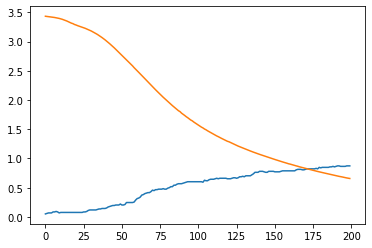

In [23]:
#plotting model accuracy
plt.plot(train.history['accuracy'],  label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')

**Testing**

In [ ]:
#chatting
import random

while True:
  texts_p=[]
  prediction_input = input('You: ')

  #removing punctutation and converting to lowercase
  prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input= tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Bot: " ,random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break
